Point 1: ($\alpha_1, \delta_1$), Point 2: ($\alpha_2, \delta_2$)

Angular separation $\phi$ between unit vectors -

$$\cos(\phi) = \hat{r_1} \cdot \hat{r_2}$$

$$\Rightarrow \cos(\phi) = \cos(\delta_1) \cos(\delta_2) \cos(\alpha_1) \cos(\alpha_2) + \cos(\delta_1) \cos(\delta_2) \sin(\alpha_1) \sin(\alpha_2) + \sin(\delta_1) \sin(\delta_2)$$

$$\boxed{\phi = \arccos[ \cos(\delta_1) \cos(\delta_2) \cos(\alpha_1) \cos(\alpha_2) + \cos(\delta_1) \cos(\delta_2) \sin(\alpha_1) \sin(\alpha_2) + \sin(\delta_1) \sin(\delta_2)]}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

Define function to find $\phi$

In [3]:
def calc_phi(alpha_1, delta_1, alpha_2, delta_2):
    
    cos_phi = np.dot([np.cos(delta_1)*np.cos(alpha_1), np.cos(delta_1)*np.sin(alpha_1), np.sin(delta_1)],
                      [np.cos(delta_2)*np.cos(alpha_2), np.cos(delta_2)*np.sin(alpha_2), np.sin(delta_2)])
    
    phi = np.arccos(cos_phi)
    
    return phi

Load in coordinates and redshifts for my catalog

In [4]:
cat_file = np.loadtxt(rootdir + 'test_new_updated.cat')

In [5]:
x_world = cat_file[:,1]
y_world = cat_file[:,2]

In [6]:
x_world_deg = [x*units.deg for x in x_world]
y_world_deg = [y*units.deg for y in y_world]

In [7]:
x_world_rad = [x.to(units.rad) for x in x_world_deg]
y_world_rad = [y.to(units.rad) for y in y_world_deg]

In [8]:
ra_new_hms = [Angle(x).hms for x in x_world_deg]
dec_new_dms = [Angle(y).dms for y in y_world_deg]

In [9]:
ra_new_hms_str = ['%02d'%int(x[0])+'h'+'%02d'%int(x[1])+'m'+'%.1f'%np.round(x[2],2)+'s' for x in ra_new_hms]
dec_new_dms_str = ['+'+'%02d'%int(y[0])+'d'+'%02d'%int(y[1])+'m'+'%.1f'%np.round(y[2],1)+'s' for y in dec_new_dms]

In [10]:
gal_ids_arr = np.int_(cat_file[:,0])

In [11]:
z_ids_arr = cat_file[:,12]

Load in Hsiao-Wen's catalog

In [12]:
cat_file_old = np.loadtxt(rootdir + 'gal_z_hwc.dat', dtype=str, delimiter=', ')

In [13]:
ra_old_arr = cat_file_old[:,0]
dec_old_arr = cat_file_old[:,1]
z_old = cat_file_old[:,2]

In [14]:
ra_old_hms = [Angle(str(a)) for a in ra_old_arr]
dec_old_dms = [Angle(str(d)) for d in dec_old_arr]

In [15]:
ra_old_deg = [a.deg*units.deg for a in ra_old_hms]
dec_old_deg = [d.deg*units.deg for d in dec_old_dms]

In [16]:
ra_old_rad = [a.to(units.rad) for a in ra_old_deg]
dec_old_rad = [d.to(units.rad) for d in dec_old_deg]

Calculate grid of $\phi$ values

In [17]:
phi_grid = np.zeros((len(x_world_rad), len(ra_old_rad)))

In [18]:
for i in range(len(x_world_rad)):
    for j in range(len(ra_old_rad)):
        
        ra_new = x_world_rad[i]
        dec_new = y_world_rad[i]
        
        ra_old = ra_old_rad[j]
        dec_old = dec_old_rad[j]
        
        phi_grid[i,j] = calc_phi(ra_new, dec_new, ra_old, dec_old)

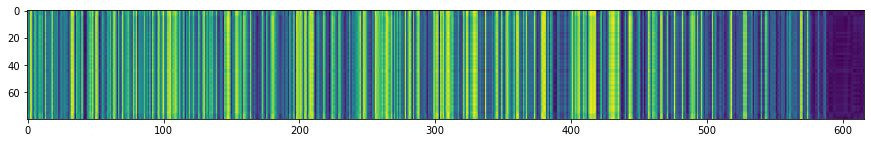

In [19]:
fig, ax = plt.subplots(1, figsize=(15, 7))

ax.imshow(phi_grid)

(array([4888., 5306., 7222., 8197., 3480., 2237., 3761., 5121., 5647.,
        3421.]),
 array([3.69837095e-07, 3.07994452e-04, 6.15619066e-04, 9.23243681e-04,
        1.23086830e-03, 1.53849291e-03, 1.84611752e-03, 2.15374214e-03,
        2.46136675e-03, 2.76899137e-03, 3.07661598e-03]),
 <BarContainer object of 10 artists>)

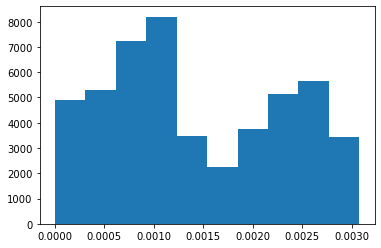

In [20]:
plt.hist(phi_grid.flatten())

In [21]:
phi_grid_arcsec = np.zeros((len(x_world_rad), len(ra_old_rad)))

In [22]:
for i in range(len(x_world_rad)):
    
    for j in range(len(ra_old_rad)):
        
        phi_grid_arcsec[i,j] = (phi_grid[i,j]*units.radian).to(units.arcsecond).value

(array([4888., 5306., 7222., 8197., 3480., 2237., 3761., 5121., 5647.,
        3421.]),
 array([7.62843767e-02, 6.35284159e+01, 1.26980547e+02, 1.90432679e+02,
        2.53884811e+02, 3.17336942e+02, 3.80789074e+02, 4.44241205e+02,
        5.07693337e+02, 5.71145468e+02, 6.34597600e+02]),
 <BarContainer object of 10 artists>)

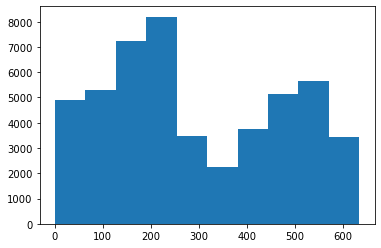

In [23]:
plt.hist(phi_grid_arcsec.flatten())

Construct the matches based on an angular separation cut-off

In [24]:
match_idx_new, match_idx_old = np.where(phi_grid_arcsec<=1)

In [25]:
import pandas as pd

In [26]:
df_list = []

for i in range(len(match_idx_new)):
            
    df_list.append([gal_ids_arr[match_idx_new[i]], 
                    ra_new_hms_str[match_idx_new[i]], dec_new_dms_str[match_idx_new[i]], z_ids_arr[match_idx_new[i]],
                    ra_old_arr[match_idx_old[i]], dec_old_arr[match_idx_old[i]], z_old[match_idx_old[i]],
                    '%.4f'%np.round(phi_grid_arcsec[match_idx_new[i], match_idx_old[i]], 4)+'"'])

In [60]:
df = pd.DataFrame(df_list, columns=['ID', 'New RA', 'New Dec',
                                    'New redshift',
                                    'Old RA', 'Old Dec',
                                    'Old redshift','Angular separation'])

In [61]:
#blankIndex=[''] * len(df)
#df.index=blankIndex

In [62]:
df['Redshift difference'] = df['New redshift']-np.float_(df['Old redshift'])

In [63]:
df['Velocity difference (km/s)'] = np.int_(np.round(df['Redshift difference']*3*10**5))

In [64]:
len(df)

42

In [65]:
df

,ID,New RA,New Dec,New redshift,Old RA,Old Dec,Old redshift,Angular separation,Redshift difference,Velocity difference (km/s)
0,1,15h24m25.8s,+09d58m2.8s,0.5356,15h24m25.77s,+09d58m02.6s,0.5354,"0.3658""",0.0002,60
1,2,15h24m25.2s,+09d58m1.9s,0.4581,15h24m25.24s,+09d58m01.7s,0.4581,"0.4797""",0.0000,0
2,3,15h24m23.1s,+09d58m0.3s,0.9576,15h24m23.08s,+09d58m00.0s,0.9586,"0.5296""",-0.0010,-300
3,5,15h24m24.9s,+09d58m0.1s,0.8217,15h24m24.97s,+09d58m00.0s,0.8216,"0.2859""",0.0001,30
4,18,15h24m24.9s,+09d58m54.4s,-0.0005,15h24m24.90s,+09d58m54.0s,0.0000,"0.5779""",-0.0005,-150
5,19,15h24m23.6s,+09d58m59.8s,0.4784,15h24m23.63s,+09d58m59.6s,0.4789,"0.3892""",-0.0005,-150
6,20,15h24m23.4s,+09d58m59.1s,0.1393,15h24m23.37s,+09d58m58.6s,0.1391,"0.5425""",0.0002,60
7,25,15h24m23.0s,+09d58m53.9s,1.1935,15h24m23.01s,+09d58m53.5s,1.1940,"0.5061""",-0.0005,-150
8,27,15h24m23.9s,+09d58m52.3s,1.0959,15h24m23.95s,+09d58m52.0s,1.0970,"0.5533""",-0.0011,-330
9,39,15h24m26.2s,+09d58m46.1s,1.3379,15h24m26.29s,+09d58m45.7s,1.3380,"0.6890""",-0.0001,-30


In [67]:
df = df.drop(df.index[[16, 17, 18, 19, 20, 28, 33]])

In [72]:
df

,ID,New RA,New Dec,New redshift,Old RA,Old Dec,Old redshift,Angular separation,Redshift difference,Velocity difference (km/s)
0,1,15h24m25.8s,+09d58m2.8s,0.5356,15h24m25.77s,+09d58m02.6s,0.5354,"0.3658""",0.0002,60
1,2,15h24m25.2s,+09d58m1.9s,0.4581,15h24m25.24s,+09d58m01.7s,0.4581,"0.4797""",0.0000,0
2,3,15h24m23.1s,+09d58m0.3s,0.9576,15h24m23.08s,+09d58m00.0s,0.9586,"0.5296""",-0.0010,-300
3,5,15h24m24.9s,+09d58m0.1s,0.8217,15h24m24.97s,+09d58m00.0s,0.8216,"0.2859""",0.0001,30
4,18,15h24m24.9s,+09d58m54.4s,-0.0005,15h24m24.90s,+09d58m54.0s,0.0000,"0.5779""",-0.0005,-150
5,19,15h24m23.6s,+09d58m59.8s,0.4784,15h24m23.63s,+09d58m59.6s,0.4789,"0.3892""",-0.0005,-150
6,20,15h24m23.4s,+09d58m59.1s,0.1393,15h24m23.37s,+09d58m58.6s,0.1391,"0.5425""",0.0002,60
7,25,15h24m23.0s,+09d58m53.9s,1.1935,15h24m23.01s,+09d58m53.5s,1.1940,"0.5061""",-0.0005,-150
8,27,15h24m23.9s,+09d58m52.3s,1.0959,15h24m23.95s,+09d58m52.0s,1.0970,"0.5533""",-0.0011,-330
9,39,15h24m26.2s,+09d58m46.1s,1.3379,15h24m26.29s,+09d58m45.7s,1.3380,"0.6890""",-0.0001,-30


In [68]:
idx =  df['New redshift']>=0

In [69]:
z_old = np.float_(np.array(df['Old redshift'][idx]))
z_old

array([0.5354, 0.4581, 0.9586, 0.8216, 0.4789, 0.1391, 1.194 , 1.097 ,
       1.338 , 0.701 , 0.1202, 0.1202, 0.653 , 1.226 , 0.5724, 0.7294,
       0.519 , 0.    , 0.    , 1.3351, 0.3286, 0.3191, 0.5205, 0.618 ,
       1.339 , 0.376 , 0.995 , 1.339 , 0.6179, 0.6184, 1.339 , 0.678 ,
       0.0965])

In [70]:
z_new = np.array(df['New redshift'][idx])
z_new

array([5.3560e-01, 4.5810e-01, 9.5760e-01, 8.2170e-01, 4.7840e-01,
       1.3930e-01, 1.1935e+00, 1.0959e+00, 1.3379e+00, 7.0100e-01,
       1.2040e-01, 1.2030e-01, 6.5310e-01, 1.2256e+00, 5.7230e-01,
       7.2930e-01, 5.1910e-01, 2.0000e-04, 8.1520e-01, 1.3348e+00,
       3.2860e-01, 3.1980e-01, 5.2050e-01, 6.1740e-01, 1.3392e+00,
       3.7520e-01, 2.9150e-01, 1.3379e+00, 6.1780e-01, 6.1830e-01,
       1.3393e+00, 6.7800e-01, 9.6600e-02])

Text(0, 0.5, '$z_{new}$')

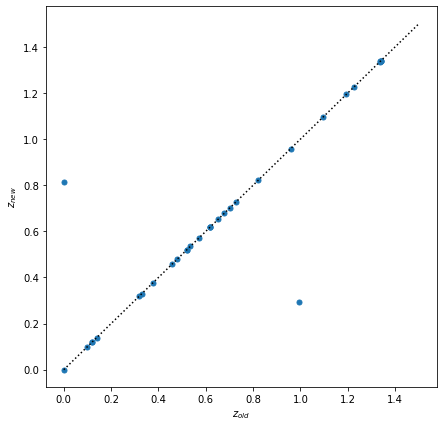

In [71]:
fig, ax = plt.subplots(1, figsize=(7,7))

ax.scatter(z_old, z_new, s=25)
ax.plot([0,1.5],[0,1.5], color='black', linestyle=':')

ax.set_xlabel(r'$z_{old}$')
ax.set_ylabel(r'$z_{new}$')

#ax.set_xticks(np.arange(0, 1.5, 0.2))
#ax.set_yticks(np.arange(0, 1.5, 0.2))

#ax.set_xlim(0, 1.5)
#ax.set_ylim(0, 1.5)